In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras_tuner as kt


df_not_outliers = pd.read_csv('../intermedio_sin_outliers.csv')

X_sin_outliers = df_not_outliers.drop(columns=['Precio_usd'])
y_sin_outliers = df_not_outliers['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled_sin_outliers = scaler.fit_transform(X_sin_outliers)

# Split sin outliers
X_train_sin_outliers, X_test_sin_outliers, y_train_sin_outliers, y_test_sin_outliers = train_test_split(
    X_scaled_sin_outliers, y_sin_outliers, test_size=0.2, random_state=42
)


In [14]:
# Modelo
def build_model2(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train_sin_outliers.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar mejores hiperparámetros
tuner2.search(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Mejor modelo
best_model_sinOutlier = tuner2.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 56s]
val_mae: 14788.7412109375

Best val_mae So Far: 3960.275146484375
Total elapsed time: 00h 09m 29s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner2.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model2(best_hp3)
history2 = model3.fit(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_data=(X_test_sin_outliers, y_test_sin_outliers),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 18500.2500 - mae: 18492.0410 - val_loss: 5192.1689 - val_mae: 5172.8589
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6663.3945 - mae: 6642.7866 - val_loss: 4888.2886 - val_mae: 4864.4907
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6112.4683 - mae: 6087.9658 - val_loss: 4540.5361 - val_mae: 4514.2129
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5874.0923 - mae: 5847.3359 - val_loss: 4523.3755 - val_mae: 4495.5820
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5646.6260 - mae: 5618.8130 - val_loss: 4408.1392 - val_mae: 4379.1597
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5580.4648 - mae: 5551.3633 - val_loss: 4404.1284 - val_mae: 4374.3643
Epoch 7/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5546.8955 - mae: 5516.8745 - val_loss: 4478.4956 - val_mae: 4447.4375
Epoch 8/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5621.9126 - mae: 5590.7632 -

In [4]:
y_pred = model3.predict(X_test_sin_outliers).flatten()

mae = mean_absolute_error(y_test_sin_outliers, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_sin_outliers, y_pred))
r2 = r2_score(y_test_sin_outliers, y_pred)
mape = np.mean(np.abs((y_test_sin_outliers - y_pred) / y_test_sin_outliers)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")



115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- MÉTRICAS ---
MAE: $4,657
RMSE: $12,020
R2: 0.674
MAPE: 44.42%


In [5]:
dataset1 = pd.read_csv('../dataset_basico.csv')

X1, y1 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X1)

# Split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y1, test_size=0.2, random_state=42)


In [6]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train1.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train1, y_train1, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 49s]
val_mae: 12445.51171875

Best val_mae So Far: 3117.839599609375
Total elapsed time: 00h 08m 43s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
y_pred = best_model.predict(X_test1).flatten()

mae = mean_absolute_error(y_test1, y_pred)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred))
r2 = r2_score(y_test1, y_pred)
mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- MÉTRICAS ---
MAE: $3,034
RMSE: $4,643
R2: 0.809
MAPE: 12.71%


In [8]:
# Recuperar los mejores hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model1 = build_model(best_hp)
history1 = model1.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=50,
    batch_size=32,
    verbose=1
)



Epoch 1/50


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 17025.5332 - mae: 17020.6328 - val_loss: 3523.3496 - val_mae: 3510.8872
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4313.8262 - mae: 4301.1367 - val_loss: 3556.1060 - val_mae: 3542.8342
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4194.6045 - mae: 4181.2681 - val_loss: 3379.4641 - val_mae: 3365.6719
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4064.6218 - mae: 4050.6777 - val_loss: 3246.9802 - val_mae: 3232.7288
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4063.9990 - mae: 4049.4866 - val_loss: 3181.8606 - val_mae: 3166.9707
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3928.2646 - mae: 3913.2883 - val_loss: 3136.7795 - val_mae: 3121.3035
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3890.5249 - mae: 3875.0083 - val_loss: 3292.4490 - val_mae: 3276.5393
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4043.6829 - mae: 4027.5947 - val_loss: 

In [9]:
dataset1 = pd.read_csv('../dataset_final.csv')

X2, y2 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(X2)

# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y2, test_size=0.2, random_state=42)


In [10]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train2.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train2, y_train2, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 57s]
val_mae: 3909.57470703125

Best val_mae So Far: 3795.010498046875
Total elapsed time: 00h 08m 51s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model(best_hp3)
history3 = model3.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 18670.5078 - mae: 18661.5840 - val_loss: 7242.4438 - val_mae: 7222.4053
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6607.1758 - mae: 6586.3525 - val_loss: 5425.5771 - val_mae: 5402.0649
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6129.0454 - mae: 6104.8872 - val_loss: 5144.9136 - val_mae: 5119.0215
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5727.5220 - mae: 5700.9077 - val_loss: 4538.3921 - val_mae: 4511.0396
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5457.7764 - mae: 5429.9341 - val_loss: 5101.6421 - val_mae: 5073.9204
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5471.3818 - mae: 5443.2578 - val_loss: 4593.7842 - val_mae: 4564.7236
Epoch 7/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5247.3872 - mae: 5218.1016 - val_loss: 4504.2544 - val_mae: 4474.8784
Epoch 8/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5180.2725 - mae: 5150.7563 -

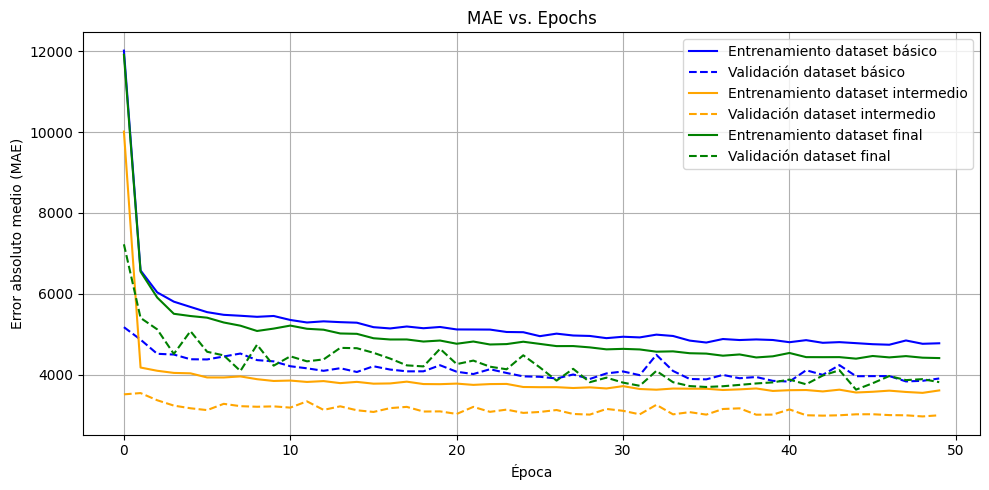

In [16]:

plt.figure(figsize=(10, 5))
plt.plot(history2.history['mae'], label='Entrenamiento dataset básico',color='blue')
plt.plot(history2.history['val_mae'], label='Validación dataset básico',color='blue', linestyle='--')
plt.plot(history1.history['mae'], label='Entrenamiento dataset intermedio',color='orange')
plt.plot(history1.history['val_mae'], label='Validación dataset intermedio', linestyle='--', color='orange')
plt.plot(history3.history['mae'], label='Entrenamiento dataset final',color='green')
plt.plot(history3.history['val_mae'], label='Validación dataset final', linestyle='--', color='green')
plt.title('MAE vs. Epochs')
plt.xlabel('Época')
plt.ylabel('Error absoluto medio (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
